In [1]:
%cd /mnt/home/zzhang/ceph/cancer-net

/mnt/ceph/users/zzhang/cancer-net


In [2]:
import os
import pnet_utils
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch_geometric.utils import subgraph
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

import torch, torch_geometric.transforms as T, torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_scatter import scatter_mean, scatter_add
from torch_geometric.nn import MetaLayer
from torch_geometric.utils import subgraph
from torch_geometric.nn import global_mean_pool, global_max_pool, GlobalAttention

%run arch/net

In [3]:
class EdgeModel(torch.nn.Module):
    def __init__(self,node_size,edge_attr_size,hidden):
        super(EdgeModel, self).__init__()
        self.edge_mlp = Seq(Lin(node_size*2+edge_attr_size, hidden),
                            ReLU(),
                            Lin(hidden, hidden))

    def forward(self, src, dest, edge_attr, u, batch):
        """
         Function to update edge attribtes. Takes as input:
             - src: [E, F_x]  where E is the number of edges, F_x are the node features
                              of the sending node.
             - dest: [E, F_x] the node features for the "receiving" nodes.
             - edge_attr: [E, F_e] where F_e are the edge features.
             - u: global features, not currently used.
             - batch: [E] with max entry B - 1.
        
         returns: [E, F_h] where F_h is the size of the hidden layers. These constitute
                           the updated edge features after a "message pass" step.
        """
        if len(edge_attr.shape)==1:
            out = torch.cat([src, dest, edge_attr.reshape(-1, 1)], 1)
        else:
            out = torch.cat([src, dest, edge_attr], 1)
        return self.edge_mlp(out)

    
class NodeModel(torch.nn.Module):
    def __init__(self,input_size,hidden):
        super(NodeModel, self).__init__()
        self.message_function = Seq(Lin(input_size+hidden, hidden),
                              ReLU(), 
                              Lin(hidden, hidden),
                              ReLU(),
                              Lin(hidden, hidden))
        self.node_mlp = Seq(Lin(input_size+hidden, hidden),
                              ReLU(), 
                              Lin(hidden, hidden),
                              ReLU(),
                              Lin(hidden, hidden))

    def forward(self, x, edge_index, edge_attr, u, batch):
        """
         Update node attributes - takes node features & edge features, updates node features
         based on the features of the sending and receiving node, and edge features of each connection.
             - x: [N, F_x] where N is the number of nodes, F_x are the node features. NB that
                           F_x can be different for different layers of the graph (i.e. the input
                           feature size is currently 3, while the latent node feature size is
                           of size `hidden`.
             - edge_index: [2,E] where E is the number of edges. List of indices describing the sending
                                 and receiving nodes of each edge.
             - edge_attr: [E, F_e] where F_e are the edge features. NB this can also be different
                                   for different layers.
             - u: Global features, not currently used.
             - batch: [E] with max entry B - 1.
        
         returns: [N, F_h] where F_h is the size of the hidden layers.
        """
        send_idx, rec_idx = edge_index ## Indices of sending and receiving nodes
        out = torch.cat([x[send_idx], edge_attr], dim=1) ## Tensor of node features of sending nodes, concatenated with the edge features
        out = self.message_function(out)
        out = scatter_add(out, rec_idx, dim=0, dim_size=x.size(0)) ## Aggregation step - for each receiving node, take the average of the hidden layer outputs connected to that node
        ## Finally concat each node feature with the hidden layer outputs, pass to one final MLP
        return self.node_mlp(torch.cat([x, out], dim=1)) 
    

class GlobalModel(torch.nn.Module):
    def __init__(self, hidden, outputs):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(hidden, hidden),
                              BatchNorm1d(hidden),
                              ReLU(),
                              Lin(hidden, outputs))

    def forward(self, x, edge_index, edge_attr, u, batch):
        """
         Aggregate node features. Global mean pool, then pass the pooled features
         to a MLP.
        """
        out = scatter_mean(x, batch, dim=0)
        out = self.global_mlp(out)
        return out

    
class InteractionNetworkMulti(torch.nn.Module):
    def __init__(self,layers,hidden):
        """
         Class to stack multiple MetaLayers
            - layers: Number of MetaLayer graphs to construct
            - hidden: Sets the latent space size of the edge, node, and global model MLPs.
                      This also sets the size of the latent space representation of the edge
                      and node features after a single MetaLayer pass.
                      
        The general procedure for the MetaLayer is as follows.
            1. The EdgeModel takes the node features and edge features. For each edge connection,
               the node and edge features for each edge are concatenated together and passed to
               an MLP. The output is then a set of u pdated node features.
            2. The NodeModel takes the updated edge features, concatenates them each with the 
               node features of the *sending* node, and passes this tensor to an MLP.
               For each receiving node, the output of this MLP is then summed over in an aggregation step.
               These aggregated features are then concatenated with the features of the receiving node, and
               passed to another MLP. The output of this MLP then constitutes the updated node features
            3. The global model is a simple global pooling of the node features, which are then passed to an MLP
            
        For multiple "stacks" of graphs, steps 1 and 2 are repeated. Step 3 is only used for the final output of the graph.
        """
        super(InteractionNetworkMulti, self).__init__()
        self.layers=layers
        ## List for multiple graph layers
        self.graphs=nn.ModuleList()
        self.graphs.append(MetaLayer(EdgeModel(3,1,hidden), NodeModel(3,hidden), GlobalModel(hidden,1)))
        ## Add multiple graph layers
        for aa in range(self.layers-1):
            self.graphs.append(MetaLayer(EdgeModel(hidden,hidden,hidden), NodeModel(hidden,hidden), GlobalModel(hidden,1)))
        
    def forward(self, x, edge_index, edge_attr, u, batch):
        x, edge_attr, u = self.graphs[0](x, edge_index, edge_attr, None, batch)
        for aa in range(1,self.layers):
            x, edge_attr, u = self.graphs[aa](x, edge_index, edge_attr, None, batch)
        return u

    
class InteractionSubSystem(torch.nn.Module):
    def __init__(self, model_config=None, activation=None, node_subset=None, max_nodes=None):
        """
         Class to build subgraphs based on Pnet biological subprocesses, and pass these subgraphs
         as input to an InteractionNetworkMulti
        """
        super(InteractionSubSystem, self).__init__()
        # Note: this assumes each graph has the same number of max_nodes
        #self.node_subset = [n+max_nodes*i for i in range(batch) for n in node_subset]
        self.node_subset =  np.array(node_subset)
        self.max_nodes = max_nodes
        self.activation_fn = activation
        self.interactionnetwork  = InteractionNetworkMulti(layers=model_config.get("layers"), hidden=model_config.get("hidden"))

    def forward(self, x, edge_index, edge_attr, batch):
        if self.node_subset is not None:
            bs = int(batch.max()) + 1
            assert batch.shape[0] == bs*self.max_nodes
            batch_subset = np.concatenate([self.node_subset+self.max_nodes*i for i in range(bs)], axis=0).tolist()
            edge_index, edge_attr = subgraph(subset=batch_subset, edge_index=edge_index, edge_attr=edge_attr, relabel_nodes=True)
            x = x[batch_subset]
            batch = batch[batch_subset]
        u = self.interactionnetwork(x, edge_index, edge_attr, None, batch)
        if self.activation_fn is not None:
            u = self.activation_fn(u)
        return u


In [4]:
def scatter_nd(indices: torch.Tensor, updates: torch.Tensor, shape) -> torch.Tensor:
    ind1d = indices[:, 0]
    n = shape[0]
    for i in range(1, len(shape)):
        ind1d = ind1d * shape[i] + indices[:, i]
        n *= shape[i]
    ind1d.to(device)
    updates.to(device)
    zz=torch.zeros(n,device=torch.device(device))
    result = zz.scatter_add_(0, ind1d, updates).reshape(*shape)
    return result

class VisibleDense(torch.nn.Module):
    def __init__(self, pathway_map, activation=None, use_bias=True):
        super(VisibleDense, self).__init__()
        ## Import gene pathway map
        if isinstance(pathway_map, pd.DataFrame):
            self.map = pathway_map.to_numpy().astype(np.float32)
        else:
            self.map = pathway_map.astype(np.float32)
        self.units = self.map.shape[1]
        self.input_dim = self.map.shape[0]
        self.use_bias = use_bias
        ## Identify indices where we have connections
        self.nonzero_ind = torch.LongTensor(np.array(np.nonzero(self.map)).T).to(device)
        nonzero_count = self.nonzero_ind.shape[0]
        ## Builds a tensor of parameters to hold the nonzero weights
        self.kernel_vector = torch.nn.Parameter(torch.zeros(nonzero_count,)).to(device)
        self.kernel_vector.to(device)
        ## Potentially problematic line - distributes the nonzero indices to a matrix of zeroes
        
        ## Builds a tensor to hold the biases
        self.bias = torch.nn.Parameter(data=torch.zeros(self.units,))
        ## Initialise the weights and biases
        torch.nn.init.uniform_(self.kernel_vector, -0.01, 0.01)
        torch.nn.init.uniform_(self.bias, -0.01, 0.01)
        self.activation_fn = activation

    def forward(self, x):
        '''
        indices = tf.constant([[0,0], [0,1], [1,1], [2,2]])
        updates = tf.constant([9, 10, 11, 12])
        shape = tf.constant([3,3])
        scatter = tf.scatter_nd(indices, updates, shape)
        print(scatter)
        tf.Tensor(
        [[ 9 10  0]
         [ 0 11  0]
         [ 0  0 12]], shape=(3, 3), dtype=int32)
        '''
        device = self.kernel_vector.device
        self.kernel = scatter_nd(self.nonzero_ind, self.kernel_vector, shape=(self.input_dim, self.units))
        ## Multiply input vector with the sparse matrix
        out = torch.matmul(x, self.kernel.to(device))
        if self.use_bias:
            out = out + self.bias
        if self.activation_fn is not None:
            out = self.activation_fn(out)
        return out


class VisibleGraphInteractionNet(torch.nn.Module):
    def __init__(self, pathway_maps, node_index, model_config=None,sparse=False):
        """
         Model that combines a MetaLayer composed of subgraphs with a final neural layer.
             - sparse: if False, uses a single fully connected layer after the graph outputs.
                       if True, uses sparse connections for the final layer, based off Pnet masks.
        """
        super(VisibleGraphInteractionNet, self).__init__()
        self.model_config = model_config
        self.pathway_maps = pathway_maps
        self.node_index = node_index
        self.pathway_to_nodes = self.get_node_subset()
        self.subsys = torch.nn.ModuleList([
                InteractionSubSystem(
                    model_config = self.model_config,
                    node_subset = self.pathway_to_nodes[target_pathway],
                    max_nodes = len(self.node_index)
                    )
                for target_pathway in self.pathway_maps[0].columns
                ])
        hidden = self.pathway_maps[1].shape[1]
        if sparse==False:
            self.nn = Seq(
                Lin(len(self.subsys), hidden),
                ReLU(),
                Lin(hidden,2)
            )
        else:
            self.nn = Seq(
                VisibleDense(pathway_map=self.pathway_maps[1]),
                ReLU(),
                Lin(hidden,2)
            )


    def get_node_subset(self):
        pathway_to_nodes = {}
        for target_pathway in self.pathway_maps[0].columns:
            subset = [self.pathway_maps[0].index[i] for i, g in enumerate(self.pathway_maps[0][target_pathway]) if g==1]
            subset = sorted([self.node_index[g] for g in subset])
            pathway_to_nodes[target_pathway] = subset
        return pathway_to_nodes

    def forward(self, x, edge_index, edge_attr, batch):
        h = torch.cat([g(x, edge_index, edge_attr, batch) for g in self.subsys], dim=-1)
        out = self.nn(h)
        return F.log_softmax(out, dim=-1)
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
reactome_kws = dict(
    reactome_base_dir = './pnet/_database/pathways/Reactome/',
    relations_file_name = 'ReactomePathwaysRelation.txt',
    pathway_names_fn = 'ReactomePathways.txt',
    pathway_genes_fn = 'ReactomePathways.gmt',
)
reactome = pnet_utils.ReactomeNetwork(reactome_kws)

In [6]:
dataset = pnet_utils.PnetDataSet(
    root="./data/prostate",
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose([T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]))

## loads the train/valid/test split from pnet
dataset.split_index_by_file(
    train_fp="./data/prostate/splits/training_set_0.csv",
    valid_fp="./data/prostate/splits/validation_set.csv",
    test_fp="./data/prostate/splits/test_set.csv"
)

In [7]:
maps = pnet_utils.get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction='root_to_leaf',
    add_unk_genes=False,
    verbose=True
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [8]:
maps[0].sum(axis=0).sort_values(ascending=False).head(20)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
R-HSA-199991     382.0
R-HSA-556833     366.0
R-HSA-1280215    339.0
R-HSA-422475     285.0
R-HSA-9006934    268.0
R-HSA-5663202    245.0
R-HSA-194315     218.0
R-HSA-5663205    206.0
R-HSA-2262752    186.0
R-HSA-9006925    180.0
R-HSA-5683057    168.0
R-HSA-195721     165.0
R-HSA-71291      165.0
R-HSA-72203      163.0
R-HSA-71387      161.0
dtype: float64

In [9]:
# use only top subsys
#n_top = 12
#maps[0] = maps[0][maps[0].sum(axis=0).sort_values(ascending=False).head(n_top).index]
maps[0].head()

,R-HSA-5683057,R-HSA-373753,R-HSA-71291,R-HSA-5205685,R-HSA-75072,R-HSA-422475,R-HSA-165159,R-HSA-73864,R-HSA-199991,R-HSA-597592,...,R-HSA-5619115,R-HSA-445717,R-HSA-196854,R-HSA-71737,R-HSA-6794362,R-HSA-5668914,R-HSA-76002,R-HSA-157118,R-HSA-1280215,R-HSA-75205
A1CF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADACL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
maps[0].shape

(9054, 146)

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = "cpu"

print(device)

cuda


In [12]:
batch = 10

# prep data
train_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=True,
)

valid_loader = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=True,
)

In [13]:
parall = False
lr = 0.001  ## Learning rate
inputs = 3  ## Input node feature size
outputs = 1 ## Output dimensions of each subgraph
hidden = 16 ## Size of hidden layers in graphs (both the MLP size and latent representation of nodes and edge)
layers = 2  ## Number of graphs to stack

model = VisibleGraphInteractionNet(
    pathway_maps = maps,
    node_index = dataset.node_index,
    #edge_model=edge_model, node_model=node_model, global_model=global_model,
    model_config = {'inputs':inputs, 'outputs':outputs, 'hidden':hidden, 'layers':layers},
).to(device)

print(count_parameters(model),"learnable parameters in model")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
criterion = F.nll_loss

875496 learnable parameters in model


In [14]:
data = next(iter(train_loader))
data = data.to(device)
out = model(data.x, data.edge_index, data.edge_attr, data.batch)
out = out.detach().cpu().numpy()
np.exp(out)

array([[0.53043437, 0.46956563],
       [0.5304743 , 0.4695256 ],
       [0.5313874 , 0.4686126 ],
       [0.53001994, 0.46998003],
       [0.53061277, 0.46938735],
       [0.53012705, 0.46987292],
       [0.5305374 , 0.46946257],
       [0.53023946, 0.46976054],
       [0.5302135 , 0.46978658],
       [0.53055584, 0.46944413]], dtype=float32)

Checking if this works
```python
data = next(iter(train_loader))
data = data.to(device)
out = model(data.x, data.edge_index, data.edge_attr, data.batch)
out = out.detach().cpu().numpy()
np.exp(out)
```

In [15]:
t0 = time.time()
def train(epoch, report=True, progbar=False):
    model.train()
    global t0
    total_loss = 0
    correct = 0
    num_samps = 0
    gen = tqdm.tqdm(train_loader) if progbar is True else train_loader
    for data in gen:
        if not parall:
            data = data.to(device)
        optimizer.zero_grad()

        output = model(data.x,data.edge_index,data.edge_attr,data.batch)
        output = output.squeeze()

        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y

        if len(output.shape) == 1:
            output = output.unsqueeze(0)
        loss = criterion(output, y)

        pred = output.max(1)[1]
        correct += pred.eq(y).sum().item()
        total_loss += loss * batch
        loss.backward()
        optimizer.step()
        num_samps += len(y)
    if report:
        print(
            "Epoch: {:02d}, Loss: {:.3g}, Train Acc: {:.4f}, Time lapsed: {:.1f} s".format(
                epoch, total_loss / num_samps, correct / num_samps,
                time.time() - t0
            )
        )
        t0 = time.time()

    return total_loss / num_samps, correct / num_samps

def valid():
    model.eval()
    correct = 0

    total_loss = 0
    num_samps = 0
    for data in valid_loader:
        if not parall:
            data = data.to(device)
        output = model(data.x,data.edge_index,data.edge_attr,data.batch)
        output = output.squeeze()

        pred = output.max(1)[1]
        if parall:
            y = torch.cat([d.y for d in data]).to(output.device)
        else:
            y = data.y
        loss = criterion(output, y)
        total_loss += loss.item() * batch

        correct += pred.eq(y).sum().item()
        num_samps += len(y)
    return total_loss / num_samps, correct / num_samps

In [16]:
# run training
train_losses = []
train_acces = []
valid_acces = []
valid_losses = []
for epoch in range(1, 100):
    report = (epoch) % 1 == 0
    train_loss, train_acc = train(epoch, report=report)
    valid_loss, valid_acc = valid()
    scheduler.step(valid_loss)
    train_losses.append(train_loss.cpu().detach().numpy())
    valid_losses.append(valid_loss)
    train_acces.append(train_acc)
    valid_acces.append(valid_acc)
    if report:
        print("valid Loss: {:.3g}, Acc: {:.4f}".format(valid_loss, valid_acc))

Epoch: 01, Loss: 0.623, Train Acc: 0.6713, Time lapsed: 73.3 s
valid Loss: 0.655, Acc: 0.6700
Epoch: 02, Loss: 0.531, Train Acc: 0.7375, Time lapsed: 76.5 s
valid Loss: 6.2, Acc: 0.6700
Epoch: 03, Loss: 0.474, Train Acc: 0.7875, Time lapsed: 78.1 s
valid Loss: 2.15, Acc: 0.6900
Epoch: 04, Loss: 0.435, Train Acc: 0.8100, Time lapsed: 78.0 s
valid Loss: 1.24, Acc: 0.3400
Epoch: 05, Loss: 0.402, Train Acc: 0.8263, Time lapsed: 78.7 s
valid Loss: 0.5, Acc: 0.7700
Epoch: 06, Loss: 0.399, Train Acc: 0.8313, Time lapsed: 78.7 s
valid Loss: 5.91, Acc: 0.3200
Epoch: 07, Loss: 0.35, Train Acc: 0.8600, Time lapsed: 78.7 s
valid Loss: 8.12, Acc: 0.3300
Epoch: 08, Loss: 0.328, Train Acc: 0.8638, Time lapsed: 78.9 s
valid Loss: 0.818, Acc: 0.6900
Epoch: 09, Loss: 0.312, Train Acc: 0.8700, Time lapsed: 78.9 s
valid Loss: 3.8, Acc: 0.3300
Epoch: 10, Loss: 0.297, Train Acc: 0.8775, Time lapsed: 79.1 s
valid Loss: 1.12, Acc: 0.3800
Epoch: 11, Loss: 0.267, Train Acc: 0.8950, Time lapsed: 79.1 s
valid Los

Text(0, 0.5, 'Valid accuracy')

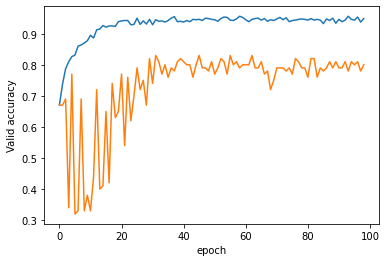

In [17]:
plt.plot(train_acces)
plt.plot(valid_acces)
plt.xlabel("epoch")
plt.ylabel("Valid accuracy")

Text(0.5, 0, 'epoch')

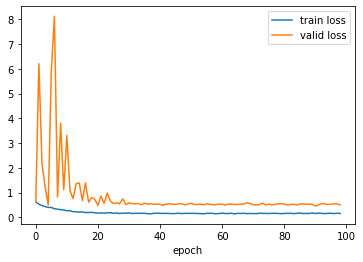

In [18]:
plt.plot(train_losses,label="train loss")
plt.plot(valid_losses,label="valid loss")
plt.legend()
plt.xlabel("epoch")
#plt.yscale("log")

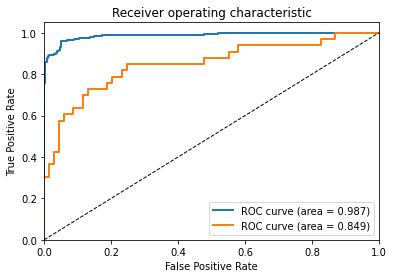

In [19]:
# vis training + validation metrics
loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.train_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_train, tpr_train, _ = roc_curve(ys, outs[:, 1])
train_auc = auc(fpr_train, tpr_train)

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.valid_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
valid_auc = auc(fpr_valid, tpr_valid)

plt.plot(
    fpr_train, tpr_train, lw=2, label="ROC curve (area = %0.3f)" % train_auc,
)
plt.plot(
    fpr_valid, tpr_valid, lw=2, label="ROC curve (area = %0.3f)" % valid_auc,
)
plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [20]:
# testing performance

loader_auc = DataLoader(
    dataset,
    batch_size=batch,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=False,
)

outs = []
ys = []
for tb in loader_auc:
    tbc = tb.cuda()
    outs.append(torch.exp(model(tb.x,tb.edge_index,tb.edge_attr,tb.batch)).cpu().data.numpy())
    ys.append(tb.y.cpu().numpy())

outs = np.concatenate(outs)
ys = np.concatenate(ys)

fpr_valid, tpr_valid, _ = roc_curve(ys, outs[:, 1])
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs[:, 1]>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs[:, 1]))
print('f1', f1_score(ys, outs[:, 1]>0.5))
print('precision', precision_score(ys, outs[:, 1]>0.5))
print('recall', recall_score(ys, outs[:, 1]>0.5))

accuracy 0.8235294117647058
auc 0.8814878892733564
aupr 0.8024613220993221
f1 0.7096774193548386
precision 0.7857142857142857
recall 0.6470588235294118
